In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import itertools
import copy
import math

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

In [2]:
class LittleBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LittleBlock, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim, bias = False)

    def forward(self, x):
        return F.relu(self.fc(x))

In [3]:
class Block(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Block, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias = False)
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias = False)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
#F1: NN + NN
class Symmetric(nn.Module):
    def __init__(self, input_dim, hidden_dim_phi, hidden_dim_rho):
        super(Symmetric, self).__init__()
        
        self.hidden_dim_phi = hidden_dim_phi
        self.hidden_dim_rho = hidden_dim_rho
        self.input_dim = input_dim
        
        self.rho = None
        self.phi = None
        self.reinit()
    
    def reinit(self):
        self.rho = Block(self.hidden_dim_phi, self.hidden_dim_rho, 1)
        self.phi = LittleBlock(self.input_dim, self.hidden_dim_phi)
    
    def forward(self, x):        
        batch_size, input_set_dim, input_dim = x.shape
        
        x = x.view(-1, input_dim)
        z = self.phi(x)
        z = z.view(batch_size, input_set_dim, -1)
        z = torch.mean(z, 1)
        return self.rho(z)
    
    def regularize(self, lamb):
        reg_loss = 0.
        W1 = self.phi.fc.weight
        W2 = self.rho.fc1.weight
        w = self.rho.fc2.weight
        
        W1 = torch.norm(W1, dim = 1, keepdim = True)
        W2 = torch.abs(W2)
        w = torch.abs(w)
        
        reg_loss = torch.matmul(w, torch.matmul(W2, W1)).item()
        
        return lamb * reg_loss

In [5]:
class DeepSets(Symmetric):
    def __init__(self, input_dim, hidden_dim_phi, hidden_dim_rho):
        super(DeepSets, self).__init__(input_dim, hidden_dim_phi, hidden_dim_rho)

    def forward(self, x):        
        batch_size, input_set_dim, input_dim = x.shape
        
        x = x.view(-1, input_dim)
        z = self.phi(x)
        z = z.view(batch_size, input_set_dim, -1)
        z = torch.sum(z, 1)
        return self.rho(z)

In [6]:
#F2: K + NN
class KNN(Symmetric):
    def __init__(self, input_dim, hidden_dim_phi, hidden_dim_rho):
        super(KNN, self).__init__(input_dim, hidden_dim_phi, hidden_dim_rho)

    def reinit(self):
        super(KNN, self).reinit()
        
        self.phi.fc.weight.requires_grad = False        
        self.phi.fc.weight.div_(torch.norm(self.phi.fc.weight, dim = 1, keepdim = True))
        
    def regularize(self, lamb):
        reg_loss = 0.

        W2 = self.rho.fc1.weight
        w = self.rho.fc2.weight
        
        W2 = torch.norm(W2, dim = 1, keepdim = True)
        w = torch.abs(w)
        
        reg_loss = torch.matmul(w, W2).item()
        
        return lamb * reg_loss

In [7]:
#F3: K + K
class KK(KNN):
    def __init__(self, input_dim, hidden_dim_phi, hidden_dim_rho):
        super(KK, self).__init__(input_dim, hidden_dim_phi, hidden_dim_rho)

    def reinit(self):
        super(KK, self).reinit()
        
        self.rho.fc1.weight.requires_grad = False        
        self.rho.fc1.weight.div_(torch.norm(self.rho.fc1.weight, dim = 1, keepdim = True))

        
    def regularize(self, lamb):
        reg_loss = 0.
        
        w = self.rho.fc2.weight

        reg_loss = torch.norm(w)

        return lamb * reg_loss

In [8]:
def generate_narrow_data(N, batch_size, input_dim, objective):
    x = np.random.uniform(low = -1, high = 1, size = (batch_size, N, input_dim))
    y = objective(x)
    
    #bias term
    x[:,:,-1] = 1
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    return (x,y)

In [9]:
def generate_wide_data(N, batch_size, input_dim, objective):
    x = np.zeros((batch_size, N, input_dim))
    for i in range(input_dim):
        
        a = np.random.uniform(low = -1, high = 1, size = batch_size)
        b = np.random.uniform(low = -1, high = 1, size = batch_size)
        a, b = np.minimum(a,b), np.maximum(a,b)

        x_fill = np.random.uniform(low = np.tile(a, (N,1)), high = np.tile(b, (N,1)))
        x[:,:,i] = x_fill.T
    
    y = objective(x)
    
    #bias term
    x[:,:,-1] = 1
    
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    return (x,y)

In [10]:
def generate_data(N, batch_size, input_dim, objective, narrow):
    if narrow:
        return generate_narrow_data(N, batch_size, input_dim, objective)
    else:
        return generate_wide_data(N, batch_size, input_dim, objective)

In [11]:
def train(model, x, y, iterations, lamb = 0.1):
    model.train()
    criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.003)
    optimizer = optim.Adam(model.parameters(), lr=0.003)

#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)

    indices = np.array_split(np.arange(x.shape[0]), x.shape[0]/20)

    losses = []
    for i in range(iterations):
        index = indices[np.random.randint(len(indices))]
        outputs = model(x[index])

        optimizer.zero_grad()
        loss = criterion(outputs, y[index])
        loss += model.regularize(lamb)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
    model.eval()
    return losses

In [12]:
def generalization_error(N_list, batch_size, model, objective, narrow):
    errors = []
    for N in N_list:
        input_dim = model.input_dim
        x,y = generate_data(N, batch_size, input_dim, objective, narrow)
        outputs = model(x)
        error = nn.MSELoss()(outputs, y).item()
        errors.append(error)
    return np.array(errors)

In [13]:
def relu(x):
    return np.maximum(x, 0)

In [14]:
mean = lambda x: np.mean(norm(x, axis = 2), axis = 1, keepdims = True)

median = lambda x: np.median(norm(x, axis = 2), axis = 1, keepdims = True)

maximum = lambda x: np.max(norm(x, axis = 2), axis = 1, keepdims = True)

lamb = 0.1
softmax = lambda x: lamb * np.log(np.mean(np.exp(norm(x, axis = 2) / lamb), axis = 1, keepdims = True))

second = lambda x: np.sort(norm(x, axis = 2), axis = 1)[:,-2].reshape(-1,1)

In [15]:
#For the rest of the notebook
input_dim = 10

In [64]:
### May need to sample several neurons to find one that isn't degenerate on the domain


teacher = Symmetric(input_dim, 10, 1)

# torch.nn.init.normal_(teacher.phi.fc.weight,std = 1.)
torch.nn.init.uniform_(teacher.phi.fc.weight, a = -0.2, b = 1.0)
# torch.nn.init.uniform_(teacher.rho.fc1.weight,a = -0.2, b = 1.0)

teacher.eval()
def neuron(x):
    x = torch.from_numpy(x).float()
    y = teacher(x)
    return y.data.numpy().reshape(-1, 1)

x, y = generate_narrow_data(3, 15, input_dim, neuron)
print(y.data.numpy().flatten())

[0.00197264 0.         0.         0.         0.         0.05057052
 0.         0.00832279 0.00692367 0.         0.01675833 0.
 0.         0.0060226  0.02592961]


In [66]:
### May need to sample several neurons to find one that isn't degenerate on the domain

smooth_teacher = Symmetric(input_dim, 20, 1)

# torch.nn.init.normal_(teacher.rho.fc1.weight,std = 1.)
# torch.nn.init.normal_(teacher.rho.fc2.weight,std = 1.)

torch.nn.init.uniform_(teacher.rho.fc1.weight,a = -0.2, b = 1.0)


smooth_teacher.eval()
def smooth_neuron(x):
    x = torch.from_numpy(x).float()
    y = smooth_teacher(x)
    return y.data.numpy().reshape(-1, 1)

x, y = generate_narrow_data(3, 10, input_dim, smooth_neuron)
print(y.data.numpy().flatten())

[ 0.         -0.0046459  -0.00360234 -0.0004428   0.          0.
 -0.00473162  0.          0.         -0.00260649]


In [26]:
neuron.__name__ = "neuron"
smooth_neuron.__name__ = "smooth_neuron"
maximum.__name__ = "maximum"
softmax.__name__ = "softmax"
median.__name__ = "median"
mean.__name__ = "mean"
second.__name__ = "second"

In [27]:
###############################################

In [28]:
def cross_validate(model, x, y, iterations, lambs, verbose):
    models = []
    for lamb in lambs:
        model_copy = copy.deepcopy(model)
        losses = train(model_copy, x, y, iterations, lamb)
        models.append(model_copy)
        if verbose and lamb == 0:
            print("check for overfitting power of", model.__name__)
            print(losses[::int(iterations/10)])
            print(np.min(np.array(losses)))
    return models

In [32]:
def compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, objective, narrow, verbose = True, log_plot = False, scaleup = False):
    print("currently", objective.__name__)
        
#     f1 = Symmetric(input_dim, 1000, hidden_dim)
#     f2 = KNN(input_dim, 1000, hidden_dim)
#     f3 = KK(input_dim, 1000, 1000)

    c = 1 if not scaleup else 2
    print(c)

    f1 = Symmetric(input_dim, c * hidden_dim, hidden_dim)
    f2 = KNN(input_dim, c * hidden_dim, hidden_dim)
    f3 = KK(input_dim, c * hidden_dim, hidden_dim)

    f1.__name__ = "S1"
    f2.__name__ = "S2"
    f3.__name__ = "S3"

    models = [f1, f2, f3]
    
    lambs = [0., 1e-6, 1e-4, 1e-2]
    N_list = np.arange(2, N_max + 16)

    for model in models:
        x, y = generate_data(N_max, batch_size, input_dim, objective, narrow)
        cv_models = cross_validate(model, x, y, iterations, lambs, verbose)
        
        validation_errors = np.zeros_like(lambs)
        for i, cv_model in enumerate(cv_models):
            validation_errors[i] = generalization_error([N_max], 1000, cv_model, objective, narrow)[0]
        
        i = np.argmin(validation_errors)
        lamb = lambs[i]
            
        runs = 10
        run_errors = np.zeros((runs, len(N_list)))
        for i in range(runs):
            x, y = generate_data(N_max, batch_size, input_dim, objective, narrow)
            model_copy = copy.deepcopy(model)
            model_copy.reinit()
            train(model_copy, x, y, iterations, lamb)
            errors = generalization_error(N_list, 1000, model_copy, objective, narrow)
            run_errors[i] = np.array(errors)
        
        mean_error = np.mean(run_errors, axis = 0)
        std_error = np.std(run_errors, axis = 0)
        if verbose:
            print("performance of ", model.__name__, " on ", objective.__name__)
            print("lamb =", lamb)
            print(mean_error)
            print(std_error)
            
            
        narrow_str = "Narrow" if narrow else "Wide"
        scaleup_str = "scaleup" if scaleup else ""
        save_str = model.__name__ + "_" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str
            
        np.save(save_str + "_mean", mean_error)
        np.save(save_str + "_std", std_error)
        
        if log_plot:
            plt.semilogy(N_list, mean_error, label = model.__name__)
        else:
            plt.plot(N_list, mean_error, label = model.__name__)
        plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)

    
    plt.legend()
    plt.ylim([1e-5, 1e-1]) 

    plt.xlabel("N")
    plt.ylabel("Mean Square Error")
    narrow_str = "Narrow" if narrow else "Wide"
    plt.title(narrow_str + " generalization for " + objective.__name__)
    scaleup_str = "scaleup" if scaleup else ""
    plt.savefig("plots_high_dim/" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str)
#     plt.show()
    plt.close()

In [58]:
def plot_from_memory(yrange, objectives, narrows, scaleup):
    models = ["S1", "S2", "S3"]
    input_dim = 10
    scaleup_str = "scaleup" if scaleup else ""
    N_list = np.arange(2, 4 + 16)
    
    for objective in objectives:
        for narrow in narrows:
            
            for model in models:
    
                save_str = model + "_" + objective + "_" + narrow + "_" + str(input_dim) + scaleup_str

                mean_error = np.load(save_str + "_mean" + ".npy")
                std_error = np.load(save_str + "_std" + ".npy")

                plt.semilogy(N_list, mean_error, label = model)
                plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)


            plt.legend()
            plt.ylim(yrange) 

            plt.xlabel("N")
            plt.ylabel("Mean Square Error")
            narrow_str = narrow
            plt.title(narrow_str + " generalization for " + objective)
    #         plt.savefig("plots_high_dim/" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str)
            plt.show()
            plt.close()

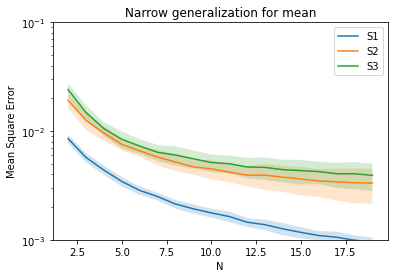

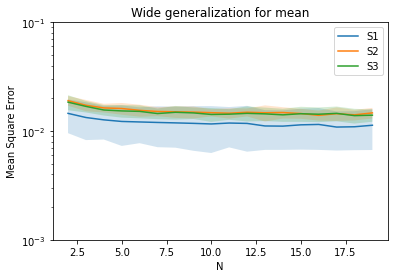

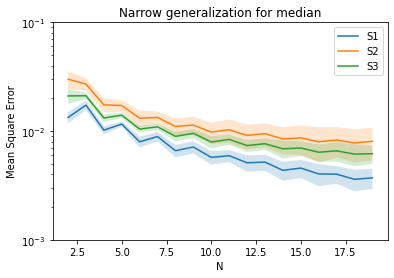

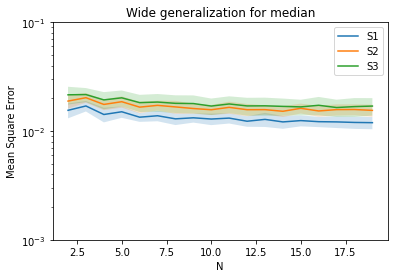

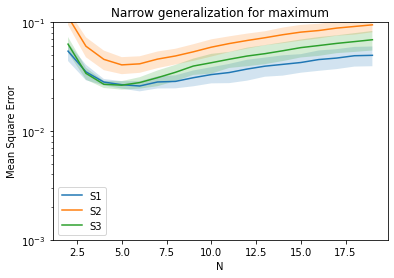

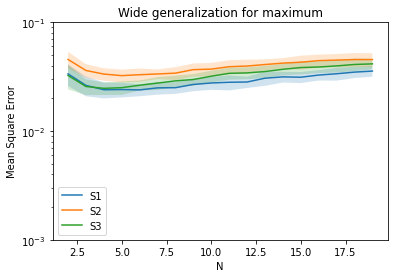

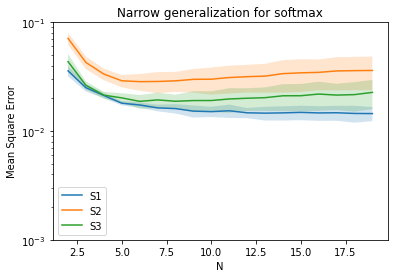

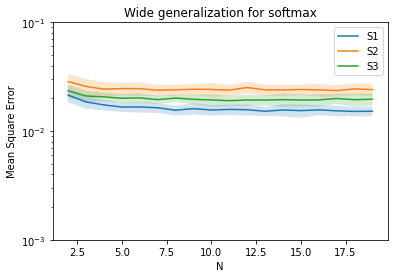

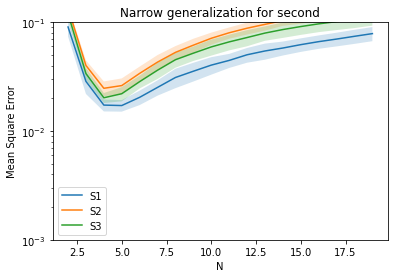

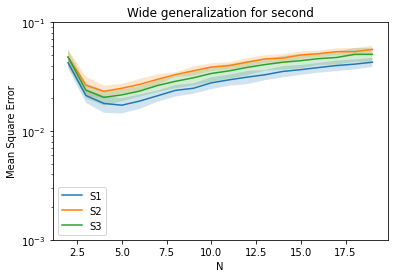

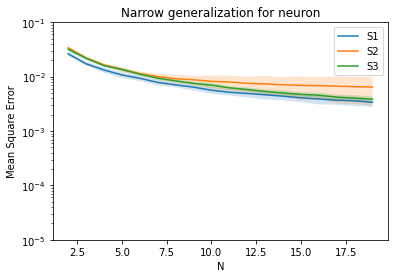

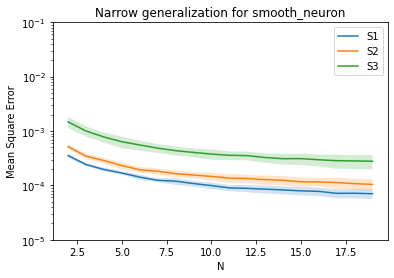

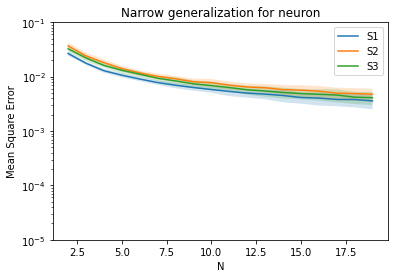

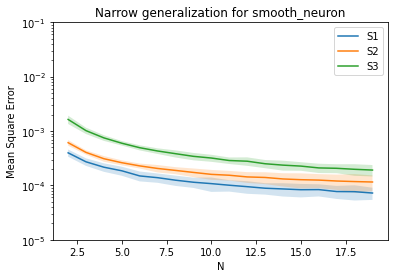

In [60]:
plot_from_memory([1e-3, 1e-1], ["mean", "median", "maximum", "softmax", "second"], ["Narrow", "Wide"], False)
plot_from_memory([1e-5, 1e-1], ["neuron"], ["Narrow"], True)
plot_from_memory([1e-5, 1e-1], ["smooth_neuron"], ["Narrow"], True)
plot_from_memory([1e-5, 1e-1], ["neuron"], ["Narrow"], False)
plot_from_memory([1e-5, 1e-1], ["smooth_neuron"], ["Narrow"], False)


In [33]:
#Run to generate plots in Figure 1:

N_max = 4
hidden_dim = 100

iterations = 5000
batch_size = 100

In [37]:
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, mean, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , mean, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, median, narrow = False, log_plot = True)
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , median, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, maximum, narrow = False, log_plot = True)
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , maximum, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, softmax, narrow = False, log_plot = True)
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , softmax, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, second, narrow = False, log_plot = True)
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , second, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, neuron, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, smooth_neuron, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True)

currently median
1
check for overfitting power of S1
[2.3399040699005127, 0.0006310543394647539, 9.246812987839803e-05, 2.2998905478743836e-05, 6.3678535298095085e-06, 3.8410662455135025e-06, 0.0016606010030955076, 1.144353745985427e-06, 4.3245526626378705e-07, 0.00010240163828711957]
2.4734617909416556e-08
performance of  S1  on  median
lamb = 0.01
[0.01552402 0.01702287 0.01420795 0.01505496 0.01342035 0.01383511
 0.0129568  0.01324687 0.01290546 0.01316508 0.01231993 0.01281025
 0.01214244 0.01248749 0.0122043  0.0121453  0.01200904 0.01194971]
[0.00242455 0.00188036 0.00218782 0.00180678 0.00126362 0.00152491
 0.00159668 0.00128202 0.00156436 0.00143028 0.00136868 0.00189757
 0.00164391 0.00143541 0.0013313  0.00147829 0.00153166 0.0015508 ]
check for overfitting power of S2
[1.9182935953140259, 0.0032252618111670017, 0.0003710161545313895, 3.0461393180303276e-05, 1.175829311250709e-05, 0.00028288387693464756, 0.00010822030162671581, 0.00011457008076831698, 0.00018123703193850815, 

performance of  S3  on  maximum
lamb = 0.01
[0.06307796 0.03395226 0.02694078 0.0264384  0.02792882 0.03099479
 0.03473357 0.03964565 0.04252786 0.04576681 0.04900563 0.05153245
 0.05481788 0.05855959 0.06118861 0.06403426 0.06652888 0.06920785]
[0.01020803 0.00424135 0.002033   0.00238169 0.00336864 0.00511073
 0.00591136 0.00678523 0.00878102 0.00771084 0.00949949 0.01026619
 0.01074624 0.01102311 0.01203859 0.0119461  0.01305073 0.01411499]
currently softmax
1
check for overfitting power of S1
[2.4258177280426025, 0.0003947131335735321, 4.5753993617836386e-05, 2.647430846991483e-06, 7.832434079091399e-08, 8.090937626548111e-07, 0.00036084704333916306, 0.00016089405107777566, 1.8840840994016617e-06, 0.0018094796687364578]
8.258814965245165e-09
performance of  S1  on  softmax
lamb = 0.01
[0.021432   0.01855251 0.01739877 0.01665154 0.01666156 0.01638717
 0.0155564  0.01608795 0.0156212  0.01581888 0.0157291  0.01522326
 0.01563376 0.01542315 0.01567542 0.01536676 0.0151603  0.01522831

check for overfitting power of S3
[4.435436725616455, 0.01228999998420477, 0.00503979716449976, 0.004060836974531412, 0.00602130638435483, 0.004563499707728624, 0.0037673444021493196, 0.0028657629154622555, 0.004587873350828886, 0.002769774990156293]
0.0012622849317267537
performance of  S3  on  second
lamb = 0.01
[0.12013472 0.03380732 0.02025305 0.02206321 0.02849769 0.03630885
 0.04533982 0.05207015 0.05944699 0.06612532 0.07252902 0.07970149
 0.0858808  0.09151114 0.09691402 0.10160488 0.10526725 0.11155826]
[0.01446497 0.00423502 0.00213504 0.00329497 0.00384958 0.00615565
 0.007054   0.00791471 0.01002787 0.01090474 0.01227175 0.01199968
 0.01393555 0.01483061 0.01564379 0.01665887 0.01664948 0.01821904]


In [ ]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = True)
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = False)
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = False)




currently neuron
2
check for overfitting power of S1
[0.9773293733596802, 0.00017947649757843465, 5.620980232379225e-07, 0.0002787812554743141, 0.00016343247261829674, 1.2807247458113125e-06, 0.005152763798832893, 1.1046144265947078e-07, 0.0001808365195756778, 3.932723302568775e-06]
2.835642744919431e-12
performance of  S1  on  neuron
lamb = 1e-06
[0.06947384 0.04813424 0.03709226 0.0302854  0.02558384 0.02234142
 0.02012986 0.0177564  0.0165254  0.01500962 0.01375926 0.013019
 0.01195219 0.01126837 0.01116342 0.0103679  0.00999166 0.00931209]
[0.00893972 0.00580391 0.00599047 0.00418223 0.003722   0.00313677
 0.00327004 0.00283563 0.00255624 0.00294985 0.00264631 0.0025181
 0.00250337 0.00221859 0.00252432 0.00231868 0.00226371 0.00226107]
check for overfitting power of S2
[1.7728770971298218, 0.002813649596646428, 0.00024259548808913678, 7.84549138188595e-06, 4.642716788794132e-08, 0.00023675251577515155, 0.00020096714433748275, 0.00038795641739852726, 3.3856889785965905e-05, 5.91328

performance of  S2  on  smooth_neuron
lamb = 0.0
[6.32140280e-05 3.54592674e-05 2.55045198e-05 1.94688131e-05
 1.62305004e-05 1.40368814e-05 1.21317589e-05 1.12706322e-05
 1.01207030e-05 9.26492389e-06 8.82922686e-06 8.37715720e-06
 7.91075649e-06 7.57492410e-06 7.30036038e-06 6.93433160e-06
 6.75487802e-06 6.54576399e-06]
[1.31843145e-05 8.20406368e-06 6.80181301e-06 5.03870919e-06
 4.36426229e-06 4.23479868e-06 3.80744290e-06 4.21593504e-06
 3.42287897e-06 3.34355378e-06 2.98211697e-06 3.11884368e-06
 2.88195577e-06 3.09901859e-06 2.93983763e-06 2.86407275e-06
 2.85999250e-06 2.69096210e-06]
check for overfitting power of S3
[0.01328955590724945, 3.2843345252331346e-05, 1.1241179890930653e-05, 7.211447609734023e-06, 4.764437562698731e-06, 1.2607699318323284e-05, 1.3220843584349495e-06, 1.6453329862997634e-06, 1.1659920346573927e-05, 1.3073624813841889e-06]
1.524077788417344e-07


In [36]:
# load_str = "S1" + "_" + "mean" + "_" + "Narrow" + "_" + "10" + "_mean" + ".npy"
# print(np.load(load_str))

[0.0085357  0.00572552 0.00438036 0.00344477 0.00284778 0.00249861
 0.00213494 0.00192774 0.00176821 0.00163866 0.0014521  0.00137651
 0.00126126 0.00117016 0.00109527 0.0010556  0.00099244 0.00095536]


In [ ]:
N_max = 4
hidden_dim = 100
iterations = 5000
batch_size = 100

objective = neuron
narrow = True


x, y = generate_data(N_max, batch_size, input_dim, objective, narrow)

for i in range(5):
        
    model = Symmetric(input_dim, hidden_dim, hidden_dim)
    model.train()
    losses = train(model, x, y, iterations, lamb = 0.00000)
    model.eval()
    print(losses[::int(iterations/10)])
    print("min", np.min(np.array(losses)))
    print("f1", generalization_error([4], 5000, model, objective, narrow))
                
    model = KNN(input_dim, hidden_dim, hidden_dim)
    model.train()
    losses = train(model, x, y, iterations, lamb = 0.000)
    model.eval()
    print(losses[::int(iterations/10)])
    print("min", np.min(np.array(losses)))
    print("f2", generalization_error([4], 5000, model, objective, narrow))
    
    model = KK(input_dim, hidden_dim, hidden_dim)
    model.train()
    losses = train(model, x, y, iterations, lamb = 0.0)
    model.eval()
    print(losses[::int(iterations/10)])
    print("min", np.min(np.array(losses)))
    print("f3", generalization_error([4], 5000, model, objective, narrow))

In [ ]:
###############################################

In [ ]:
#Plot for Figure 3

# N_max = 4
# hidden_dim = 50

# iterations = 1000
# batch_size = 100

# input_dim = 5

# objective = mean
# narrow = False

# log_plot = True

# f1 = Symmetric(input_dim, 1000, hidden_dim)
# f2 = DeepSets(input_dim, 1000, hidden_dim)
# f1.__name__ = "S1"
# f2.__name__ = "DeepSets"

# models = [f1, f2]

# N_list = np.arange(2, N_max + 16)

# for model in models:
#     x, y = generate_data(N_max, batch_size, input_dim, objective, narrow)

#     lamb = 0.

#     runs = 10
#     run_errors = np.zeros((runs, len(N_list)))
#     for i in range(runs):
#         x, y = generate_data(N_max, batch_size, input_dim, objective, narrow)
#         model_copy = copy.deepcopy(model)
#         model_copy.reinit()
#         train(model_copy, x, y, iterations, lamb)
#         errors = generalization_error(N_list, 1000, model_copy, objective, narrow)
#         run_errors[i] = np.array(errors)

#     mean_error = np.mean(run_errors, axis = 0)
#     std_error = np.std(run_errors, axis = 0)
#     if log_plot:
#         plt.semilogy(N_list, mean_error, label = model.__name__)
#     else:
#         plt.plot(N_list, mean_error, label = model.__name__)
#     plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)


# plt.legend()
# #     plt.ylim([1e-5, 1e10]) 
# plt.xlabel("N")
# plt.ylabel("Mean Square Error")
# narrow_str = "Narrow" if narrow else "Wide"
# plt.title("Normalized vs. Unnormalized generalization for " + objective.__name__)
# plt.savefig("plots_high_dim/" + "deepsets")
# #     plt.show()
# plt.close()